[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eyaler/workshop/blob/master/nn_6_novelty.ipynb)

# 6. Novelty detection


In [0]:
%tensorflow_version 1.x
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

Using TensorFlow backend.


In [0]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [0]:
# load dataset
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, y_train.shape)
gray = False
if len(x_train.shape)==4 and gray:
    x_train = np.mean(x_train, axis=-1, keepdims=True)
    x_test = np.mean(x_test, axis=-1, keepdims=True)
if len(x_train.shape)==3:
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)
train_size = len(y_train)
test_size = len(y_test)
xdim = x_train.shape[1]
ydim = x_train.shape[2]
cdim = x_train.shape[3]
print(x_train.dtype, y_train.dtype)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1)
uint8 uint8


[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]
[6]


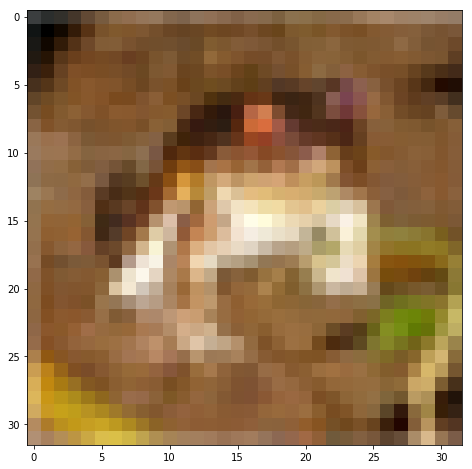

In [0]:
print(x_train[0])
print(y_train[0])
if gray:
    plt.imshow(x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(x_train[0])

In [0]:
print(np.min(x_train), np.max(x_train), np.median(x_train))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

0 255 117.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))


In [0]:
x_train = np.asarray([x for x,y in zip(x_train,y_train) if y[0]!=9])
y_train = np.asarray([y for y in y_train if y[0]!=9])

In [0]:
print(np.unique(y_train, return_counts=True))


(array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


In [0]:
n_classes = len(np.unique(y_train))
x_train, y_train = shuffle(x_train, y_train, random_state=44)
x_train = x_train/255
x_test = x_test/255
y_train = to_categorical(y_train, n_classes)

In [0]:
def get_model(bn):
    inputs = Input(shape=(xdim, ydim, cdim))
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Flatten()(f)
    f = Dense(512, activation='relu', name='embeddings')(f)
    f = Dropout(0.5)(f)
    f = Dense(n_classes, name='logits')(f)
    outputs = Activation('softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

In [0]:
model = get_model(bn=False)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.2)

W0818 11:15:39.525883 140701322028928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0818 11:15:39.528436 140701322028928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0818 11:15:39.538259 140701322028928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0818 11:15:39.590768 140701322028928 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0818 11:15:39.594286 140701322028928 deprecation_wrapp

Train on 36000 samples, validate on 9000 samples
Epoch 1/100
36000/36000 [==============================] - 15s 421us/step - loss: 2.1404 - acc: 0.1673 - val_loss: 1.9624 - val_acc: 0.2574
Epoch 2/100
36000/36000 [==============================] - 9s 244us/step - loss: 1.9336 - acc: 0.2635 - val_loss: 1.8493 - val_acc: 0.3084
Epoch 3/100
36000/36000 [==============================] - 9s 245us/step - loss: 1.7897 - acc: 0.3266 - val_loss: 1.7096 - val_acc: 0.3600
Epoch 4/100
36000/36000 [==============================] - 9s 244us/step - loss: 1.7009 - acc: 0.3674 - val_loss: 1.5952 - val_acc: 0.4097
Epoch 5/100
36000/36000 [==============================] - 9s 244us/step - loss: 1.6394 - acc: 0.3897 - val_loss: 1.5505 - val_acc: 0.4184
Epoch 6/100
36000/36000 [==============================] - 9s 244us/step - loss: 1.5847 - acc: 0.4118 - val_loss: 1.5324 - val_acc: 0.4388
Epoch 7/100
36000/36000 [==============================] - 9s 246us/step - loss: 1.5312 - acc: 0.4326 - val_loss: 1.

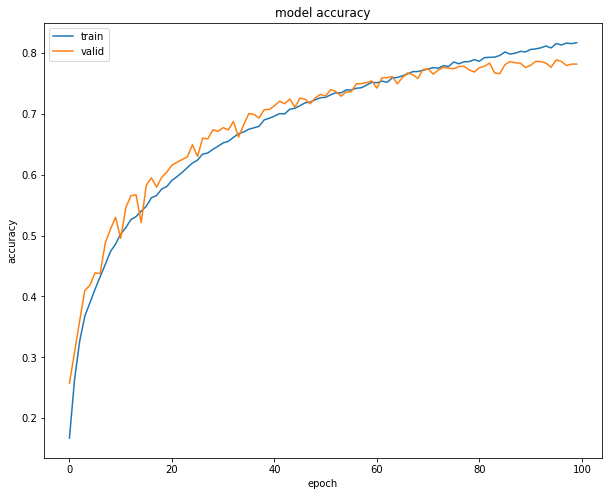

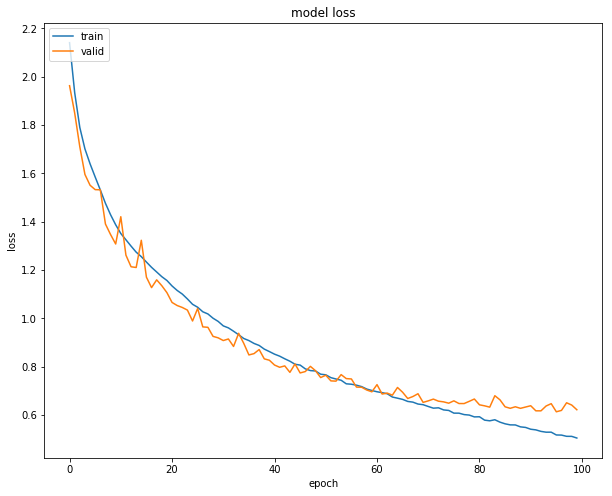

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [0]:
get_logits = Model(inputs=model.input, outputs=model.get_layer('logits').output)

(array([0.00696563, 0.04759845, 0.07836331, 0.08532894, 0.08765082,
        0.06675393, 0.05340312, 0.0505008 , 0.02728204, 0.02496018,
        0.0203164 , 0.01044844, 0.01044845, 0.00232187, 0.00464375,
        0.00116094, 0.00116094, 0.        , 0.        , 0.00116094]),
 array([ 1.3328683,  3.0556133,  4.7783585,  6.5011034,  8.223848 ,
         9.946593 , 11.669338 , 13.392084 , 15.114829 , 16.837574 ,
        18.560318 , 20.283064 , 22.00581  , 23.728554 , 25.4513   ,
        27.174044 , 28.89679  , 30.619534 , 32.342278 , 34.065025 ,
        35.78777  ], dtype=float32),
 <a list of 20 Patch objects>)

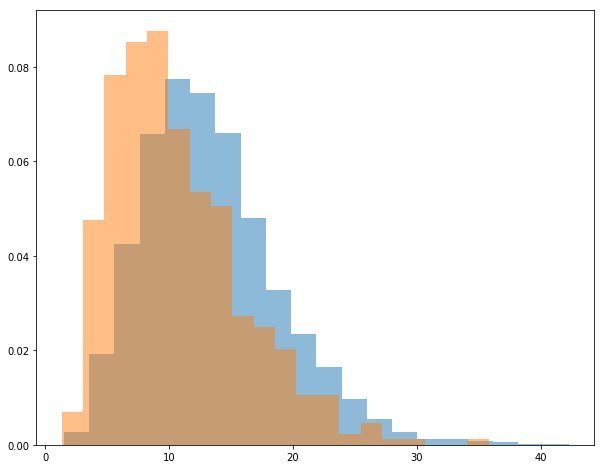

In [0]:
logits = get_logits.predict(x_test)
max_logits = np.max(logits, axis=-1)-np.min(logits, axis=-1)
logit_normal = [p for p,y in zip(max_logits, y_test) if y<9]
logit_novel = [p for p,y in zip(max_logits, y_test) if y==9]
plt.hist(logit_normal, 20, density=True, alpha=0.5, label='normal')
plt.hist(logit_novel, 20, density=True, alpha=0.5, label='novel')

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')

x_normal = np.asarray([x for x,y in zip(x_test,y_test) if y < 9])
x_novel = np.asarray([x for x,y in zip(x_test,y_test) if y==9])

get_emb = Model(inputs=model.input, outputs=model.get_layer('embeddings').output)
code_normal = np.reshape(get_emb.predict(x_normal),(-1,256))
code_novel = np.reshape(get_emb.predict(x_novel),(-1,256))


low = tsne.fit_transform(np.vstack((code_normal,code_novel)))

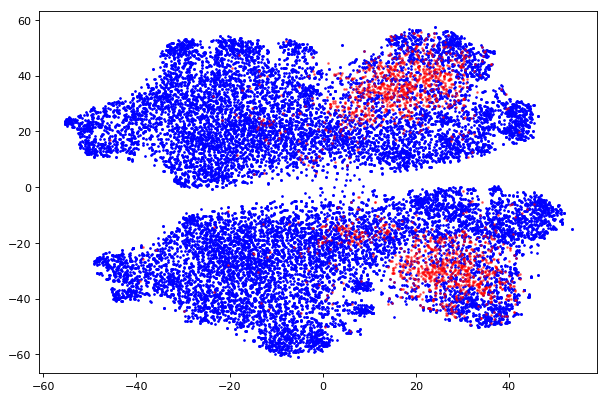

In [0]:

t_normal = low[:len(code_normal)]
t_novel = low[len(code_normal):]
fig=plt.figure(figsize=(9,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(t_normal[:,0],t_normal[:,1],color='b',s=2)
plt.scatter(t_novel[:,0],t_novel[:,1],color='r',alpha=0.5,s=2)
plt.show()